In [149]:
import pandas as pd
import numpy as np

In [150]:
df = pd.read_csv('data.csv')

In [151]:
list(enumerate(df.columns))

[(0, 'id'),
 (1, 'name'),
 (2, 'host_id'),
 (3, 'host_name'),
 (4, 'neighbourhood_group'),
 (5, 'neighbourhood'),
 (6, 'latitude'),
 (7, 'longitude'),
 (8, 'room_type'),
 (9, 'price'),
 (10, 'minimum_nights'),
 (11, 'number_of_reviews'),
 (12, 'last_review'),
 (13, 'reviews_per_month'),
 (14, 'calculated_host_listings_count'),
 (15, 'availability_365')]

In [152]:
df['price'].isna().sum()

0

Пропусков в поле price не наблюдается, никаких дополнительных действий значит при подсчете с помощью map reduce делать не нужно :) 

In [153]:
print(f"Среднее price={df['price'].mean()}")

Среднее price=152.7206871868289


In [331]:
print(f"Дисперсия price={df['price'].var(ddof=0)}")

Дисперсия price=57672.84569843345


Т.к. мне не удалось полноценно запустить скрипты в hadoop, то я решил продемонстрировать их работоспособность тут. Также я пробовал отдельно запускать скрипты, они зпускались, но как map reduce задачи были ошибки. Я не смог найти в логах информацию о питоновских ошибках во время исполнения, поэтому решил остановиться на этом. 

## MEAN

In [349]:
import csv
from collections import deque

In [324]:
# mapper
data = deque()
with open('data_no_header.csv', 'r') as f:
    for line in csv.reader(f.readlines()):
        chunk_id = np.random.randint(1, 100)
        data.append(f"{chunk_id}\t{line[9]}")
        #print(chunk_id, line[9], sep="\t")

In [325]:
data_df = pd.DataFrame(list(map(lambda x: x.split('\t'), data)), dtype=float)

In [335]:
data_df[1].mean()

152.7206871868289

In [336]:
# combiner
data_1 = deque()

chunk_id = None
current_sum = 0
current_size = 0

for line in data:
    current_chunk_id, value = line.split("\t")
    value = int(value)
    
    if chunk_id:
        if current_chunk_id == chunk_id:
            current_size += 1
            current_sum += value
        else:
            data_1.append(f"{current_size}\t{current_sum / current_size}")
            chunk_id = current_chunk_id
            current_size = 1
            current_sum = value
    else:
        chunk_id = current_chunk_id
        current_size = 1
        current_sum = value

In [340]:
data_1_df = pd.DataFrame(list(map(lambda x: x.split('\t'), data_1)), dtype=float)
data_1_df[1].mean()

152.7274468070451

In [329]:
data_1 = sorted(data_1)

In [330]:
# reducer
sum_ = 0
size_ = 0
mean = 0

for line in data_1:
    current_size, value = line.split("\t")
    current_size = int(current_size)
    value = float(value)
    
    mean = (current_size * value + size_ * mean) / (current_size + size_)
    size_ += current_size
    
print(mean)

152.72196997586556


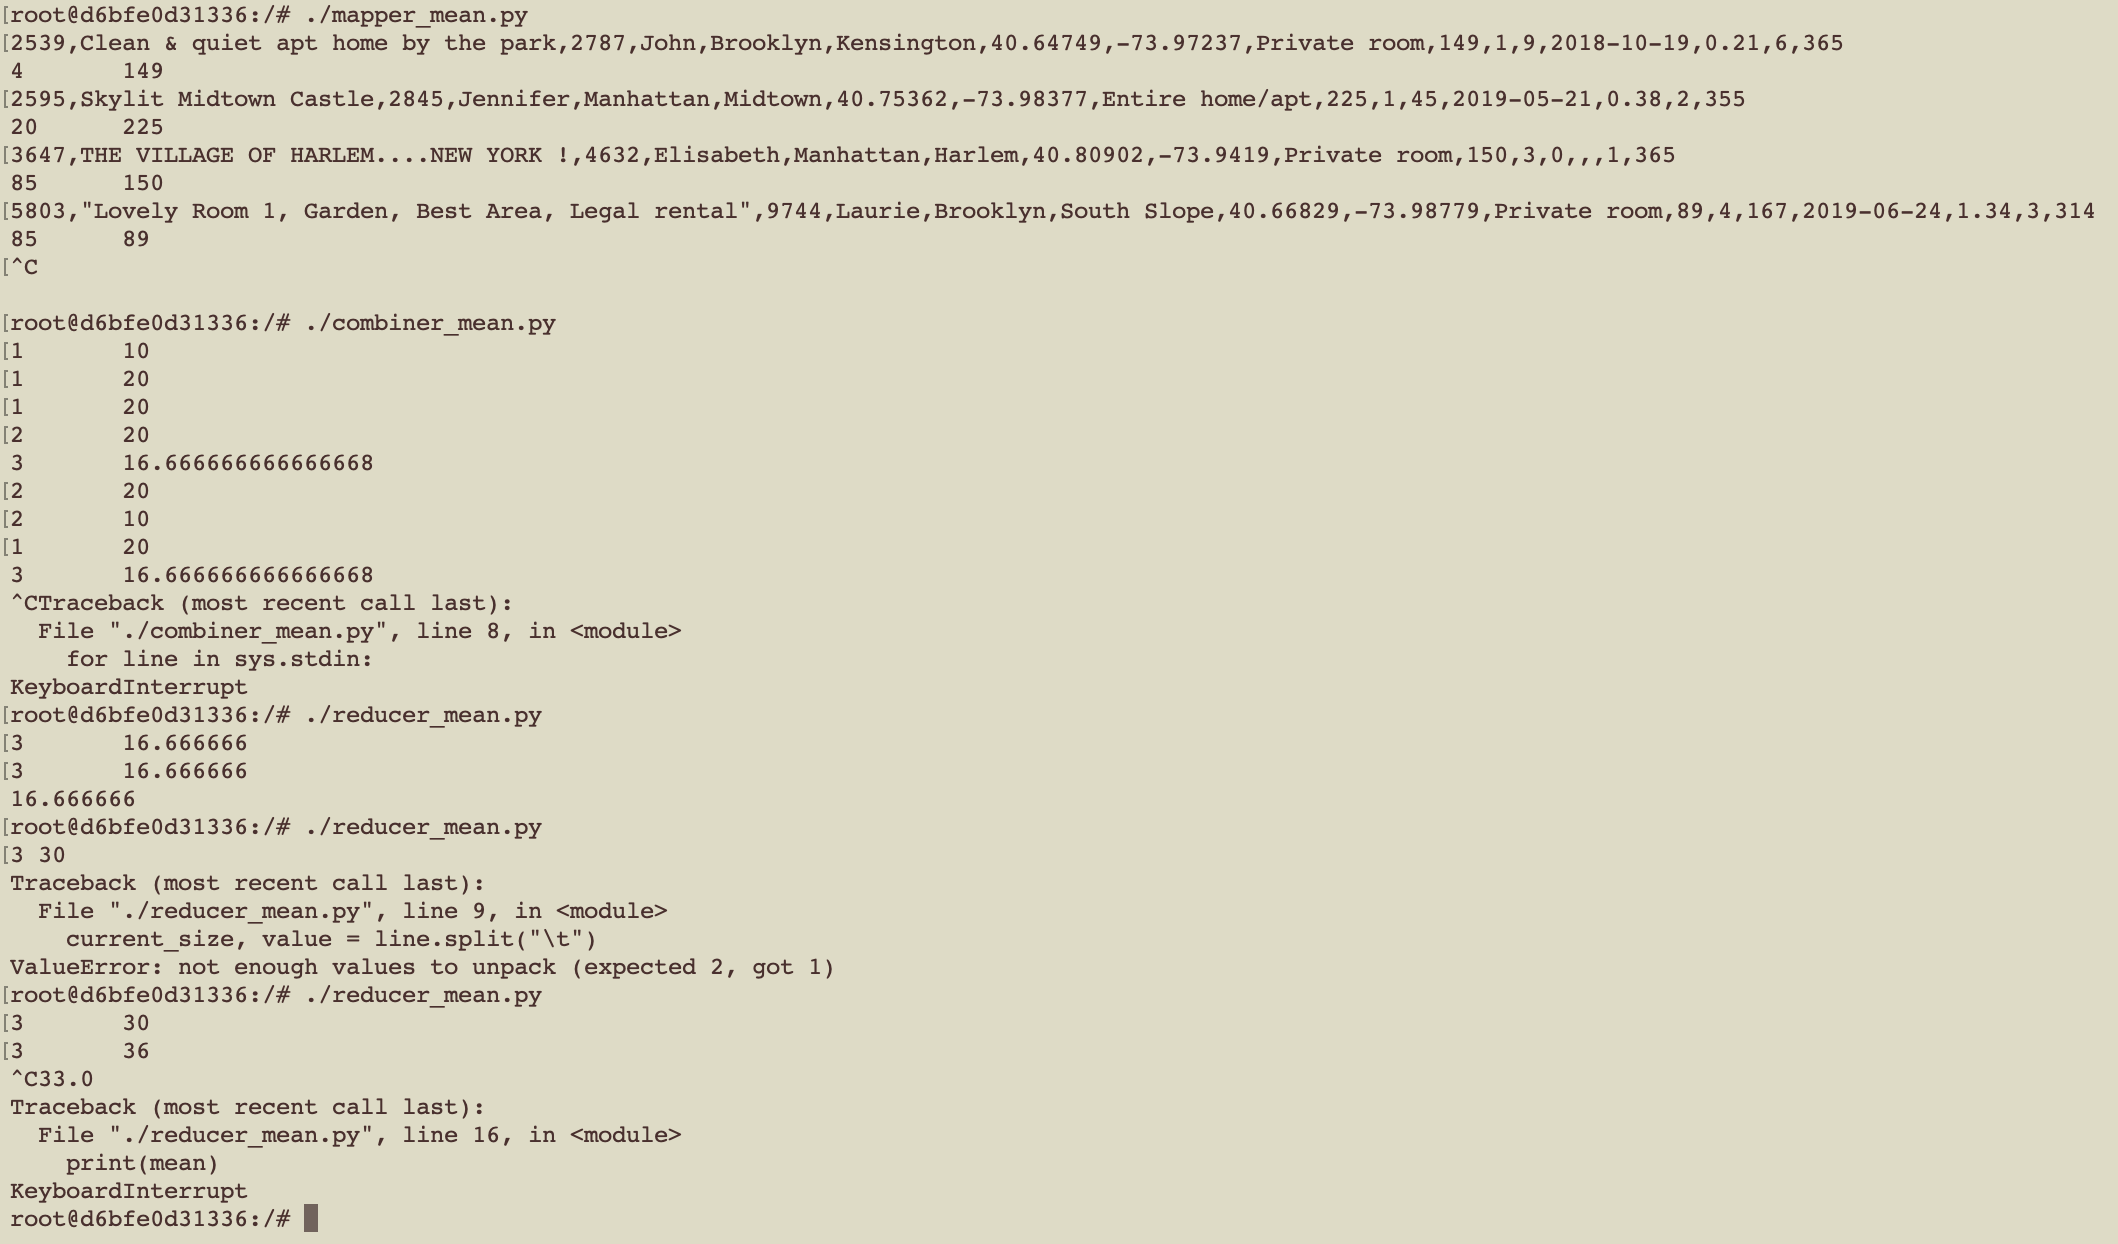

## VAR

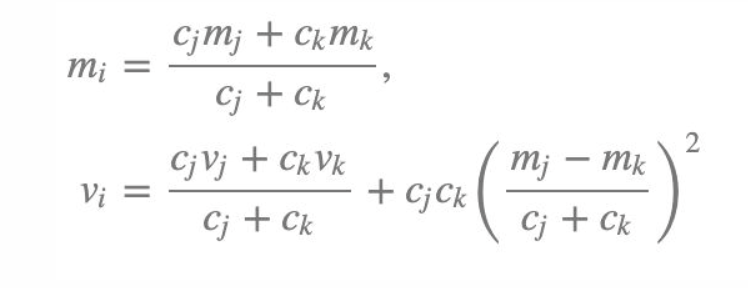

In [350]:
import csv
from collections import deque

In [351]:
# mapper
data = deque()
with open('data_no_header.csv', 'r') as f:
    for line in csv.reader(f.readlines()):
        chunk_id = np.random.randint(1, 100)
        data.append(f"{chunk_id}\t{line[9]}")
        #print(chunk_id, line[9], sep="\t")

In [354]:
CURRENT_SIZE = 1

sum_ = 0
size_ = 0
mean = 0
var = 0

for line in data:
    chunkid, value = line.split("\t")
    
    value = float(value)
    
    mean = (CURRENT_SIZE * value + size_ * mean) / (CURRENT_SIZE + size_)
    size_ += CURRENT_SIZE
    var = (size_ * var) / (CURRENT_SIZE + size_) + size_ * ((value - mean) / (CURRENT_SIZE + size_)) ** 2
    
print(mean)
print(var)

152.72068718682831
57659.47434539217
